# LIBRARIES

In [ ]:
!pip install empiricaldist statsmodels matplotlib

In [4]:
import pandas as pd
from fractions import Fraction

In [3]:
# Get utils.py
from os.path import basename, exists

# def download(url):
#     filename = basename(url)
#     if not exists(filename):
#         from urllib.request import urlretrieve
#         local, _ = urlretrieve(url, filename)
#         print('Downloaded ' + local)
    
# download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

from utils import decorate
from utils import set_pyplot_params
set_pyplot_params()

import numpy as np
import pandas as pd

from empiricaldist import Pmf
from scipy.stats import binom

import matplotlib.pyplot as plt
from utils import make_binomial
from utils import decorate
from utils import make_mixture

from scipy.interpolate import interp1d


# CHAPTER1: Probability

In [24]:
def prob(A):
    """Computes the probability of a proposition, A."""    
    return A.mean()

def conditional(proposition, given):
    """Probability of A conditioned on given."""
    return prob(proposition[given])

In [25]:
# Load the data file

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/data/gss_bayes.csv')
gss = pd.read_csv('gss_bayes.csv', index_col=0)
gss.head()

Downloaded gss_bayes.csv


,year,age,sex,polviews,partyid,indus10
caseid,,,,,,
1,1974,21.0,1,4.0,2.0,4970.0
2,1974,41.0,1,5.0,0.0,9160.0
5,1974,58.0,2,6.0,1.0,2670.0
6,1974,30.0,1,5.0,4.0,6870.0
7,1974,48.0,1,5.0,4.0,7860.0


## Exercise 1-00
**Linda the Banker**

To introduce conditional probability, I'll use an example from a [famous experiment by Tversky and Kahneman](https://en.wikipedia.org/wiki/Conjunction_fallacy), who posed the following question:

> Linda is 31 years old, single, outspoken, and very bright. She majored in philosophy. As a student, she was deeply concerned with issues of discrimination and social justice, and also participated in anti-nuclear demonstrations.  Which is more probable?
> 1. Linda is a bank teller.
> 2. Linda is a bank teller and is active in the feminist movement.

Many people choose the second answer, presumably because it seems more consistent with the description.  It seems uncharacteristic if Linda is *just* a bank teller; it seems more consistent if she is also a feminist.

## Exercise 1-01
Let's use the tools in this chapter to solve a variation of the Linda problem.

> Linda is 31 years old, single, outspoken, and very bright. She majored in philosophy. As a student, she was deeply concerned with issues of discrimination and social justice, and also participated in anti-nuclear demonstrations.  Which is more probable?
> 1. Linda is a banker.
> 2. Linda is a banker and considers herself a liberal Democrat.

To answer this question, compute 

* The probability that Linda is a female banker,

* The probability that Linda is a liberal female banker, and

* The probability that Linda is a liberal female banker and a Democrat.

In [26]:
female = (gss['sex'] == 2)
banker = (gss['indus10'] == 6870)
liberal = (gss['polviews'] <= 3)
democrat = (gss['partyid'] <= 1)

In [27]:
# Solution
print(prob(female & banker))
print(prob(female & banker & liberal))
print(prob(female & banker & liberal & democrat))

0.011381618989653074
0.002556299452221546
0.0012375735443294787


## Exercise 1-02
Use `conditional` to compute the following probabilities:

* What is the probability that a respondent is liberal, given that they are a Democrat?

* What is the probability that a respondent is a Democrat, given that they are liberal?

Think carefully about the order of the arguments you pass to `conditional`.

In [28]:
# Solution
print(conditional(liberal, given=democrat))
print(conditional(democrat, given=liberal))

0.3891320002215698
0.5206403320240125


## Exercise 1-03
There's a [famous quote](https://quoteinvestigator.com/2014/02/24/heart-head/) about young people, old people, liberals, and conservatives that goes something like:

> If you are not a liberal at 25, you have no heart. If you are not a conservative at 35, you have no brain.

Whether you agree with this proposition or not, it suggests some probabilities we can compute as an exercise.
Rather than use the specific ages 25 and 35, let's define `young` and `old` as under 30 or over 65. For these thresholds, I chose round numbers near the 20th and 80th percentiles.  Depending on your age, you may or may not agree with these definitions of "young" and "old".

I'll define `conservative` as someone whose political views are "Conservative", "Slightly Conservative", or "Extremely Conservative".

Use `prob` and `conditional` to compute the following probabilities.

* What is the probability that a randomly chosen respondent is a young liberal?

* What is the probability that a young person is liberal?

* What fraction of respondents are old conservatives?

* What fraction of conservatives are old?

For each statement, think about whether it is expressing a conjunction, a conditional probability, or both.

For the conditional probabilities, be careful about the order of the arguments.
If your answer to the last question is greater than 30%, you have it backwards!

In [29]:
young = (gss['age'] < 30)
old = (gss['age'] >= 65)
prob(young), prob(old)

(0.19435991073240008, 0.17328058429701765)

In [30]:
conservative = (gss['polviews'] >= 5)
prob(conservative)

0.3419354838709677

In [31]:
# Solution
print(prob(young & liberal))
print(conditional(liberal, given=young))
print(prob(old & conservative))
print(conditional(old, given=conservative))

0.06579427875836884
0.338517745302714
0.06701156421180766
0.19597721609113564


# CHAPTER2: Bayes's Theorem

## Exercise 2: The Cookie Problem

We'll start with a thinly disguised version of an [urn problem](https://en.wikipedia.org/wiki/Urn_problem):

> Suppose there are two bowls of cookies.
>
> * Bowl 1 contains 30 vanilla cookies and 10 chocolate cookies. 
>
> * Bowl 2 contains 20 vanilla cookies and 20 chocolate cookies.
>
> Now suppose you choose one of the bowls at random and, without looking, choose a cookie at random. If the cookie is vanilla, what is the probability that it came from Bowl 1?

What we want is the conditional probability that we chose from Bowl 1 given that we got a vanilla cookie, $P(B_1 | V)$.

In [ ]:
table = pd.DataFrame(index=['Bowl 1', 'Bowl 2'])
table['prior'] = 1/2, 1/2
table['likelihood'] = 3/4, 1/2
table['unnorm'] = table['prior'] * table['likelihood']
prob_data = table['unnorm'].sum()
table['posterior'] = table['unnorm'] / prob_data

## Exercise 2: The Dice Problem

A Bayes table can also solve problems with more than two hypotheses.  For example:

> Suppose I have a box with a 6-sided die, an 8-sided die, and a 12-sided die. I choose one of the dice at random, roll it, and report that the outcome is a 1. What is the probability that I chose the 6-sided die?

In this example, there are three hypotheses with equal prior
probabilities. The data is my report that the outcome is a 1. 

Here's a Bayes table that uses integers to represent the hypotheses:

In [44]:
def update(table):
    """Compute the posterior probabilities."""
    table['unnorm'] = table['prior'] * table['likelihood']
    prob_data = table['unnorm'].sum()
    table['posterior'] = table['unnorm'] / prob_data
    return table

In [45]:
table2 = pd.DataFrame(index=[6, 8, 12])
table2['prior'] = Fraction(1, 3)
table2['likelihood'] = Fraction(1, 6), Fraction(1, 8), Fraction(1, 12)
update(table2)

,prior,likelihood,unnorm,posterior
6,1/3,1/6,1/18,4/9
8,1/3,1/8,1/24,1/3
12,1/3,1/12,1/36,2/9


## Exercise 2: The Monty Hall Problem


Next we'll use a Bayes table to solve one of the most contentious problems in probability.

The Monty Hall problem is based on a game show called *Let's Make a Deal*. If you are a contestant on the show, here's how the game works:

* The host, Monty Hall, shows you three closed doors -- numbered 1, 2, and 3 -- and tells you that there is a prize behind each door.

* One prize is valuable (traditionally a car), the other two are less valuable (traditionally goats).

* The object of the game is to guess which door has the car. If you guess right, you get to keep the car.

Suppose you pick Door 1. Before opening the door you chose, Monty opens Door 3 and reveals a goat. Then Monty offers you the option to stick with your original choice or switch to the remaining unopened door.

To maximize your chance of winning the car, should you stick with Door 1 or switch to Door 2?

To answer this question, we have to make some assumptions about the behavior of the host:

1.  Monty always opens a door and offers you the option to switch.

2.  He never opens the door you picked or the door with the car.

3.  If you choose the door with the car, he chooses one of the other
    doors at random.

Under these assumptions, you are better off switching. 
If you stick, you win $1/3$ of the time. If you switch, you win $2/3$ of the time.

To see why, it can help to use a Bayes table. We start with three
hypotheses: the car might be behind Door 1, 2, or 3. According to the
statement of the problem, the prior probability for each door is 1/3.

In [47]:
table3 = pd.DataFrame(index=['Door 1', 'Door 2', 'Door 3'])
table3['prior'] = Fraction(1, 3)
#내가 문을 선택하는 사건의 확률은 가설과 독립적임
table3['likelihood'] = Fraction(1, 3), Fraction(1, 3), Fraction(1, 3) 
#가설과 독립적인 likelihood는 prior를 변화시키지 않음
print(update(table3))

table3['prior'] = table3['posterior']
#몬티가 문을 선택하는 사건의 확률은 가설과 종속적임
table3['likelihood'] = Fraction(1, 2), 1, 0 
#가설과 종속적인 likelihood는 prior를 변화시킴
print(update(table3)) 

       prior likelihood unnorm posterior
Door 1   1/3        1/3    1/9       1/3
Door 2   1/3        1/3    1/9       1/3
Door 3   1/3        1/3    1/9       1/3
       prior likelihood unnorm posterior
Door 1   1/3        1/2    1/6       1/3
Door 2   1/3          1    1/3       2/3
Door 3   1/3          0      0         0


## Exercise 2-01
Suppose you have two coins in a box.
One is a normal coin with heads on one side and tails on the other, and one is a trick coin with heads on both sides.  You choose a coin at random and see that one of the sides is heads.
What is the probability that you chose the trick coin?

In [48]:
# Solution
table4 = pd.DataFrame(index=['Normal', 'Trick'])
table4['prior'] = 1/2
table4['likelihood'] = 1/2, 1
update(table4)

,prior,likelihood,unnorm,posterior
Normal,0.5,0.5,0.25,0.333333
Trick,0.5,1.0,0.50,0.666667


## Exercise 2-02
Suppose you meet someone and learn that they have two children.
You ask if either child is a girl and they say yes.
What is the probability that both children are girls?

Hint: Start with four equally likely hypotheses.

In [49]:
# Solution
table5 = pd.DataFrame(index=[f'{gender1} & {gender2}' 
                                for gender1 in ['Boy', 'Girl'] 
                                for gender2 in ['Boy', 'Girl']])
table5['prior'] = 1/4
table5['likelihood'] = 0, 1, 1, 1
update(table5)

,prior,likelihood,unnorm,posterior
Boy & Boy,0.25,0,0.00,0.000000
Boy & Girl,0.25,1,0.25,0.333333
Girl & Boy,0.25,1,0.25,0.333333
Girl & Girl,0.25,1,0.25,0.333333


## Exercise 2-03: variations of the [Monty Hall problem](https://en.wikipedia.org/wiki/Monty_Hall_problem).  
For example, suppose Monty always chooses Door 2 if he can, and
only chooses Door 3 if he has to (because the car is behind Door 2).

If you choose Door 1 and Monty opens Door 2, what is the probability the car is behind Door 3?

If you choose Door 1 and Monty opens Door 3, what is the probability the car is behind Door 2?

In [50]:
table6 = pd.DataFrame(index=['Door 1', 'Door 2', 'Door 3'])
table6['prior'] = Fraction(1, 3)
table6['likelihood'] = 1, 0, 1
print(update(table6))

table7 = pd.DataFrame(index=['Door 1', 'Door 2', 'Door 3'])
table7['prior'] = Fraction(1, 3)
table7['likelihood'] = 0, 1, 0
print(update(table7))

       prior  likelihood unnorm posterior
Door 1   1/3           1    1/3       1/2
Door 2   1/3           0      0         0
Door 3   1/3           1    1/3       1/2
       prior  likelihood unnorm posterior
Door 1   1/3           0      0         0
Door 2   1/3           1    1/3         1
Door 3   1/3           0      0         0


## Exercise 2-04: M&M ★★★
M&M's are small candy-coated chocolates that come in a variety of colors.  
Mars, Inc., which makes M&M's, changes the mixture of colors from time to time.
In 1995, they introduced blue M&M's.  

* In 1994, the color mix in a bag of plain M&M's was 30\% Brown, 20\% Yellow, 20\% Red, 10\% Green, 10\% Orange, 10\% Tan.  

* In 1996, it was 24\% Blue , 20\% Green, 16\% Orange, 14\% Yellow, 13\% Red, 13\% Brown.

Suppose a friend of mine has two bags of M&M's, and he tells me
that **one is from 1994 and one from 1996**.  He won't tell me which is
which, but he gives me one M&M from each bag.  One is yellow and
one is green.  What is the probability that the yellow one came
from the 1994 bag?

Hint: The trick to this question is to define the hypotheses and the data carefully.

In [52]:
# Solution

# Hypotheses ← 가설을 만들 때 Probability of What을 생각하면서 만들자! 내가 알고 싶은 가설!
# A: yellow from 94, green from 96
# B: yellow from 96, green from 94

table8 = pd.DataFrame(index=['A', 'B'])
table8['prior'] = 1/2
table8['likelihood'] = 0.2*0.2, 0.14*0.1

update(table8)
table8

,prior,likelihood,unnorm,posterior
A,0.5,0.040,0.020,0.740741
B,0.5,0.014,0.007,0.259259


# CHAPTER3: Distributions

# CHAPTER4: Estimating Proportions

# CHAPTER5: Estimating Counts

# CHAPTER6: Odds And Addends

## Libraries

In [10]:
def odds(p):
    return p / (1-p)
def prob(o):
    return o / (o+1)
def prob2(yes, no):
    return yes / (yes + no)
def add_dist(pmf1, pmf2):
    """Compute the distribution of a sum."""
    res = Pmf()
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            q = q1 + q2
            p = p1 * p2
            res[q] = res(q) + p
    return res

In [8]:
def make_die(sides):
    outcomes = np.arange(1, sides+1)
    die = Pmf(1/sides, outcomes)
    return die

In [13]:
def add_dist(pmf1, pmf2):
    """Compute the distribution of a sum."""
    res = Pmf()
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            q = q1 + q2
            p = p1 * p2
            res[q] = res(q) + p
    return res
def add_dist_seq(seq):
    """Compute Pmf of the sum of values from seq."""
    total = seq[0]
    for other in seq[1:]:
        total = total.add_dist(other)
    return total

    git@github.com:thk-lightman/STD_ThinkBayes.git

In [12]:
from utils import decorate

def decorate_dice(title=''):
    decorate(xlabel='Outcome',
             ylabel='PMF',
             title=title)

## Exercises

  - Oliver Exercise
    - [Graph]("https://www.desmos.com/calculator/zija07zc68")

In [22]:
# a / (1+a) vs al / (1 + al)
a = np.array([0.01, 1, 0.99])
l = 0.83
a / (1+a), a*l / (1 + a*l)

(array([0.00990099, 0.5       , 0.49748744]),
 array([0.00823168, 0.45355191, 0.45106219]))

- Elvis Presley

In [ ]:
# Solution
prior_odds = odds(1/3)
post_odds = prior_odds * 2 * 1.25
prob(post_odds)

In [19]:
prob(0.83), prob(9*0.83), prob(1/9 * 0.83)

(0.45355191256830596, 0.8819362455726093, 0.0844354018311292)

In [20]:
1/9

0.1111111111111111

## Exercise 6-01: Elvis Problem

## Exercise 6-02: Rainning Seattle

## Exercise 6-03: Smoking & Cancer

## Exercise 6-04: D&D Goblin

In *Dungeons & Dragons*, the amount of damage a goblin can withstand is the sum of two six-sided dice. The amount of damage you inflict with a short sword is determined by rolling one six-sided die.
A goblin is defeated if the total damage you inflict is greater than or equal to the amount it can withstand.

Suppose you are fighting a goblin and you have already inflicted 3 points of damage. What is your probability of defeating the goblin with your next successful attack?

Hint: You can use `Pmf.sub_dist` to subtract a constant amount, like 3, from a `Pmf`.

## Exercise 6-05: 6, 8, 12 Dies

## Exercise 6-06: Betrayal at House

*Betrayal at House on the Hill* is a strategy game in which characters with different attributes explore a haunted house.  Depending on their attributes, the characters roll different numbers of dice.  For example, if attempting a task that depends on knowledge, Professor Longfellow rolls 5 dice, Madame Zostra rolls 4, and Ox Bellows rolls 3.  Each die yields 0, 1, or 2 with equal probability.  

If a randomly chosen character attempts a task three times and rolls a total of 3 on the first attempt, 4 on the second, and 5 on the third, which character do you think it was?

- roll & VR: 주사위를 굴리면, 그것에 해당하는 액션이 벌어진다. 무서운 것도 감당해야 하고, 좋은 경험도 얻을 수 있다! 와우!

In [ ]:
# Solution

die = Pmf(1/3, [0,1,2])

pmfs = {}
pmfs['Bellows'] = add_dist_seq([die]*3)
pmfs['Zostra'] = add_dist_seq([die]*4)
pmfs['Longfellow'] = add_dist_seq([die]*5)

pmfs['Zostra'](4)

pmfs['Zostra']([3,4,5]).prod()

hypos = pmfs.keys()
prior = Pmf(1/3, hypos)
prior

likelihood = prior.copy()

for hypo in hypos:
    likelihood[hypo] = pmfs[hypo]([3,4,5]).prod()
likelihood

posterior = (prior * likelihood)
posterior.normalize()
posterior

## Exercise 6-07: US Congress

There are 538 members of the United States Congress. Suppose we audit their investment portfolios and find that 312 of them out-perform the market.
Let's assume that an honest member of Congress has only a 50% chance of out-performing the market, but a dishonest member who trades on inside information has a 90% chance.  

**How many members of Congress are honest?**

In [ ]:
# Solution

n = 538
table = pd.DataFrame()

for n_honest in range(0, n+1):
    n_dishonest = n - n_honest
    dist_honest = make_binomial(n_honest, 0.5)
    dist_dishonest = make_binomial(n_dishonest, 0.9)
    dist_total = Pmf.add_dist(dist_honest, dist_dishonest)    
    table[n_honest] = dist_total
    
table.shape

data = 312
likelihood = table.loc[312]
len(likelihood)

hypos = np.arange(n+1)
prior = Pmf(1, hypos)
len(prior)

posterior = prior * likelihood
posterior.normalize()
posterior.mean()

posterior.plot(label='posterior')
decorate(xlabel='Number of honest members of Congress',
         ylabel='PMF')

print(posterior.max_prob())
print(posterior.credible_interval(0.9))

# CHAPTER7: Minimum, Maximum and Mixture

In [ ]:
def update_binomial(pmf, data):
    """Update pmf using the binomial distribution."""
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [ ]:
hypos = np.linspace(0, 1, 101)
pmf = Pmf(1, hypos)
data = 140, 250
update_binomial(pmf, data)

In [ ]:
cumulative = pmf.cumsum()

In [ ]:
def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

In [ ]:
cumulative.plot(label='CDF')
pmf.plot(label='PMF')
decorate_euro(title='Posterior distribution for the Euro problem')

In [ ]:
cumulative[0.61]

## Exercise 7:

## Exercise 7-01: D&D standard array

When you generate a D&D character, instead of rolling dice, you can use the "standard array" of attributes, which is 15, 14, 13, 12, 10, and 8.
Do you think you are better off using the standard array or (literally) rolling the dice?

Compare the distribution of the values in the standard array to the distribution we computed for the best three out of four:

* Which distribution has higher mean?  Use the `mean` method.

* Which distribution has higher standard deviation?  Use the `std` method.

* The lowest value in the standard array is 8.  For each attribute, what is the probability of getting a value less than 8?  If you roll the dice six times, what's the probability that at least one of your attributes is less than 8?

* The highest value in the standard array is 15.  For each attribute, what is the probability of getting a value greater than 15?  If you roll the dice six times, what's the probability that at least one of your attributes is greater than 15?

In [ ]:
standard = [15,14,13,12,10,8]
cdf_standard = Cdf.from_seq(standard)

cdf_best3.plot(label='best 3 of 4', color='C1', ls='--')
cdf_standard.step(label='standard set', color='C7')

decorate_dice('Distribution of attributes')
plt.ylabel('CDF');

In [ ]:
# Solution

# Here are the means
cdf_best3.mean(), cdf_standard.mean()

In [ ]:
# Solution

# And the standard deviations
cdf_best3.std(), cdf_standard.std()

In [ ]:
# Solution

# Here's the probability that a single attribute is less than 8
cdf_best3.lt_dist(8)

In [ ]:
# Solution

# And the probability that a single attribute is greater than 15
cdf_best3.gt_dist(15)

In [ ]:
# Solution

# Here are two ways to compute the probability that at
# least one attribute is less than 8
cdf_min6.lt_dist(8), 1 - (1-cdf_best3.lt_dist(8))**6

In [ ]:
# Solution

# And two ways to compute the probability that at least
# one attribute is greater than 15
cdf_max6.gt_dist(15), 1 - (1-cdf_best3.gt_dist(15))**6

# CHAPTER8: Poisson Processes

## Exercise 8: The World Cup Problem

### The World Cup Problem: Poisson distribution

In the 2018 FIFA World Cup final, France defeated Croatia 4 goals to 2.  Based on this outcome:

1. How confident should we be that France is the better team?

2. If the same teams played again, what is the chance France would win again?

To answer these questions, we have to make some modeling decisions.

* First, I'll assume that for any team against another team there is some unknown goal-scoring rate, measured in goals per game, which I'll denote with the Python variable `lam` or the Greek letter $\lambda$, pronounced "lambda".

* Second, I'll assume that a goal is equally likely during any minute of a game.  So, in a 90 minute game, the probability of scoring during any minute is $\lambda/90$.

* Third, I'll assume that a team never scores twice during the same minute.

Of course, none of these assumptions is completely true in the real world, but I think they are reasonable simplifications.
As George Box said, "All models are wrong; some are useful."
(https://en.wikipedia.org/wiki/All_models_are_wrong).

In this case, the model is useful because if these assumptions are 
true, at least roughly, the number of goals scored in a game follows a Poisson distribution, at least roughly.

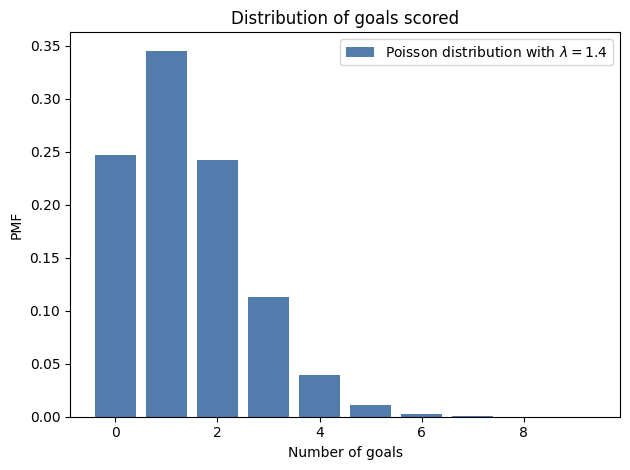

In [6]:
# LIKELIHOOD
from scipy.stats import poisson

def make_poisson_pmf(lam, qs):
    """Make a Pmf of a Poisson distribution."""
    ps = poisson(lam).pmf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

lam = 1.4
goals = np.arange(10)
pmf_goals = make_poisson_pmf(lam, goals)

def decorate_goals(title=''):
    decorate(xlabel='Number of goals',
        ylabel='PMF',
        title=title)

pmf_goals.bar(label=r'Poisson distribution with $\lambda=1.4$')

decorate_goals('Distribution of goals scored')

1.4140818156118378

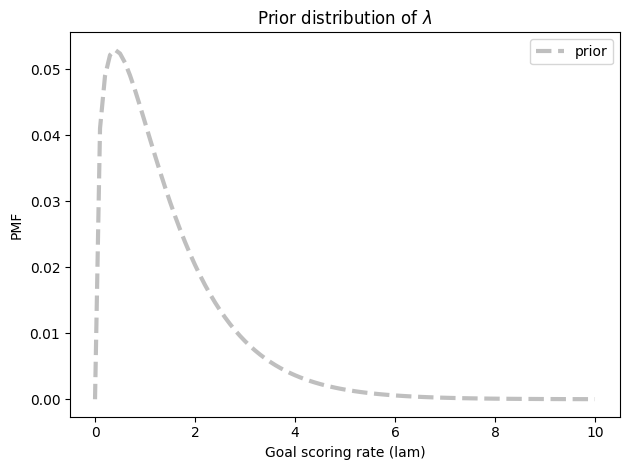

In [7]:
#PRIOR
from scipy.stats import gamma

alpha = 1.4
qs = np.linspace(0, 10, 101)
ps = gamma(alpha).pdf(qs)

prior = Pmf(ps, qs)
prior.normalize()

def decorate_rate(title=''):
    decorate(xlabel='Goal scoring rate (lam)',
        ylabel='PMF',
        title=title)

prior.plot(ls='--', label='prior', color='C5')
decorate_rate(r'Prior distribution of $\lambda$')

prior.mean()

1.6999765866755225 2.699772393342308


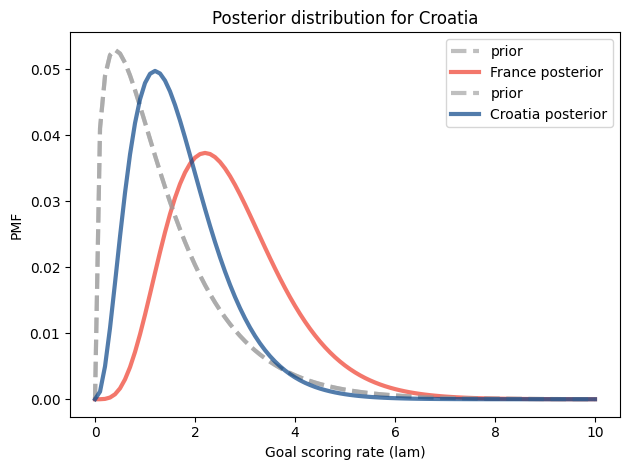

In [8]:
#UPDATE
lams = prior.qs
k = 4
likelihood = poisson(lams).pmf(k)

def update_poisson(pmf, data):
    """Update Pmf with a Poisson likelihood."""
    k = data
    lams = pmf.qs
    likelihood = poisson(lams).pmf(k)
    pmf *= likelihood
    pmf.normalize()

france = prior.copy()
update_poisson(france, 4)

prior.plot(ls='--', label='prior', color='C5')
france.plot(label='France posterior', color='C3')

decorate_rate('Posterior distribution for France')

croatia = prior.copy()
update_poisson(croatia, 2)

prior.plot(ls='--', label='prior', color='C5')
croatia.plot(label='Croatia posterior', color='C0')

decorate_rate('Posterior distribution for Croatia')

print(croatia.mean(), france.mean())

### 1.우세할 확률: 프랑스가 크로아티아보다 더 나은 팀일 가능성은 어느 정도일까?

In [9]:
# Probability of Superiority: Prior를 비교한다. 즉, 평균 득점X가 얼마일 것인지를 비교하는 것. X1 > X2일 확률을 계산하는 것. 
# 결합확률 분포를 그리고 아래바닥의 섹션에 대해 적분하면 됨. 두 사건이 독립이고 P(X1), P(X2)가 알려져 있으므로 P(X1,X2)도 알 수 있음.
def prob_gt(pmf1, pmf2):
    """Compute the probability of superiority."""
    total = 0
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            if q1 > q2:
                total += p1 * p2
    return total

prob_gt(france, croatia)
Pmf.prob_gt(france, croatia)

0.7499366290930174

### 2.다음 경기 예측: 만약 같은 팀이 다시 경기를 한다면, 프랑스가 다시 이길 확률은 얼마일까?

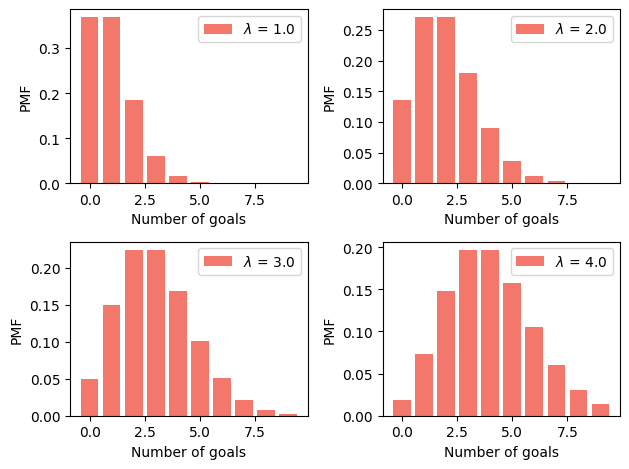

In [11]:
# Predicting the Rematch: LIKELIHOOD를 비교한다. 즉, 한 게임의 득점수Y를 비교하는 것. 즉, Y1 > Y2일 확률을 계산하는 셈.
# 결합확률 분포를 그리고 아래바닥의 섹션에 대해 적분하면 됨. 두 사건이 독립이고 P(Y1), P(Y2)가 알려져 있으므로 P(Y1,Y2)도 알 수 있음.
pmf_seq = [make_poisson_pmf(lam, goals) for lam in prior.qs]

for i, index in enumerate([10, 20, 30, 40]):
    plt.subplot(2, 2, i+1)
    lam = prior.qs[index]
    pmf = pmf_seq[index]
    pmf.bar(label=f'$\lambda$ = {lam}', color='C3')
    decorate_goals()

0.16521399583418947

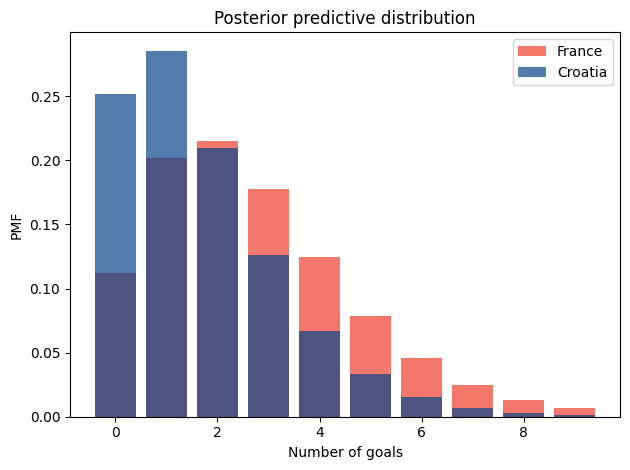

In [12]:
# P(X∧Y) → P(Y) = ∑_x P(X)P(Y|X)
pred_france = make_mixture(france, pmf_seq)
pred_france.bar(color='C3', label='France')
decorate_goals('Posterior predictive distribution')

pred_croatia = make_mixture(croatia, pmf_seq)
pred_croatia.bar(color='C0', label='Croatia')
decorate_goals('Posterior predictive distribution')

win = Pmf.prob_gt(pred_france, pred_croatia)
win
lose = Pmf.prob_lt(pred_france, pred_croatia)
lose
tie = Pmf.prob_eq(pred_france, pred_croatia)
tie

### The World Cup Problem: Exponential distribution

As an exercise at the end of this notebook, you'll have a chance to work on  the following variation on the World Cup Problem:

>In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

In this version, notice that the data is not the number of goals in a fixed period of time, but the time between goals.

To compute the likelihood of data like this, we can take advantage of the theory of Poisson processes again.  If each team has a constant goal-scoring rate, we expect the time between goals to follow an [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution).

If the goal-scoring rate is $\lambda$, the probability of seeing an interval between goals of $t$ is proportional to the PDF of the exponential distribution:

$$\lambda \exp(-\lambda t)$$

Because $t$ is a continuous quantity, the value of this expression is not a probability; it is a probability density.  However, it is proportional to the probability of the data, so we can use it as a likelihood in a Bayesian update.

SciPy provides `expon`, which creates an object that represents an exponential distribution.
However, it does not take `lam` as a parameter in the way you might expect, which makes it awkward to work with.
Since the PDF of the exponential distribution is so easy to evaluate, I'll use my own function.

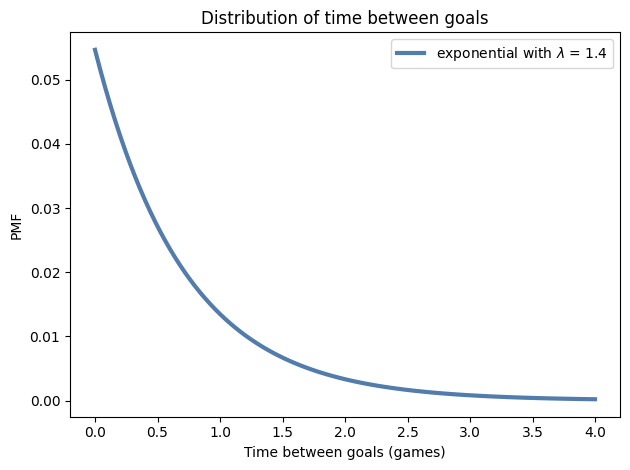

In [13]:
def expo_pdf(t, lam):
    """Compute the PDF of the exponential distribution."""
    return lam * np.exp(-lam * t)

lam = 1.4
qs = np.linspace(0, 4, 101)
ps = expo_pdf(qs, lam)
pmf_time = Pmf(ps, qs)
pmf_time.normalize()

def decorate_time(title=''):
    decorate(xlabel='Time between goals (games)',
             ylabel='PMF',
             title=title)

pmf_time.plot(label='exponential with $\lambda$ = 1.4')

decorate_time('Distribution of time between goals')

## Excercise 8 - 01: The World Cup Continued

>In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

Here are the steps I recommend:

1. Starting with the same gamma prior we used in the previous problem, compute the likelihood of scoring a goal after 11 minutes for each possible value of `lam`.  Don't forget to convert all times into games rather than minutes.

2. Compute the posterior distribution of `lam` for Germany after the first goal.

3. Compute the likelihood of scoring another goal after 12 more minutes and do another update.  Plot the prior, posterior after one goal, and posterior after two goals.

4. Compute the posterior predictive distribution of goals Germany might score during the remaining time in the game, `90-23` minutes.  Note: You will have to think about how to generate predicted goals for a fraction of a game.

5. Compute the probability of scoring 5 or more goals during the remaining time.

In [14]:
# NB와의 관계를 생각해보자. P(Y|X; D)가 독립이라는 가정하에 하는거야. 그런데 현재 우리가 배우고 있는 것의 LIKELIHOOD는 Data가 곧 Y값이야. 그런데 Data가 Y값을 동반한 X값을 가지는 경우에는 어떻게 할까? 이건 좀 더 뒤에서 회귀 아이디어 같은 것들을 배우고 나서 이해할 수 있는 부분 같아.
# Solution

# Here's a function that updates the distribution of lam
# with the given time between goals

def update_expo(pmf, data):
    """Update based on an observed interval
    
    pmf: prior PMF
    data: time between goals in minutes
    """
    t = data / 90
    lams = pmf.qs
    likelihood = expo_pdf(t, lams)
    pmf *= likelihood
    pmf.normalize()

In [15]:
# Solution

# Here are the updates for the first and second goals

germany = prior.copy()
update_expo(germany, 11)

germany2 = germany.copy()
update_expo(germany2, 12)

In [16]:
# Solution
# Here are the mean values of `lam` after each update
germany.mean(), germany2.mean()

(2.1358882653086892, 2.703059034926364)

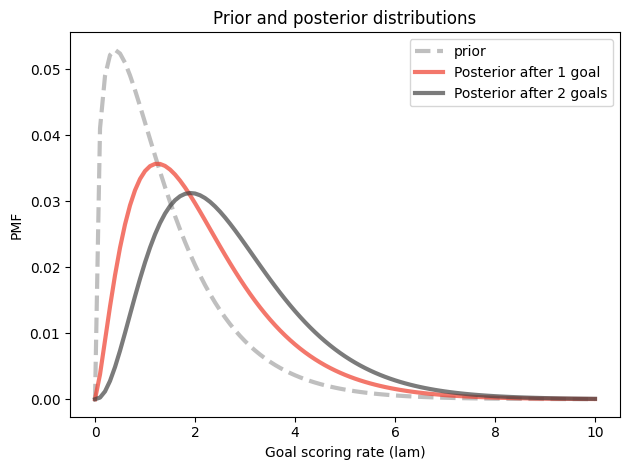

In [17]:
# Solution
# Here's what the posterior distributions look like

prior.plot(ls='--', label='prior', color='C5')
germany.plot(color='C3', label='Posterior after 1 goal')
germany2.plot(color='C16', label='Posterior after 2 goals')

decorate_rate('Prior and posterior distributions')

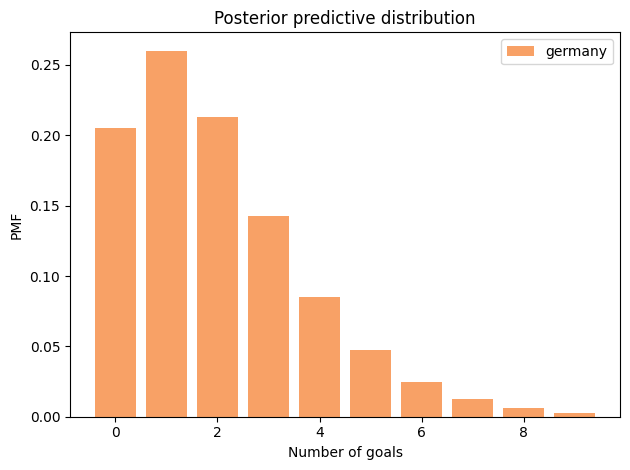

In [19]:
# Solution

# Here's the predictive distribution for each possible value of `lam`
t = (90-23) / 90
pmf_seq = [make_poisson_pmf(lam*t, goals) for lam in germany2.qs]

# And here's the mixture of predictive distributions,
# weighted by the probabilities in the posterior distribution.
pred_germany2 = make_mixture(germany2, pmf_seq)

# Here's what the predictive distribution looks like
pred_germany2.bar(color='C1', label='germany')
decorate_goals('Posterior predictive distribution')

In [20]:
# Solution

# Here's the probability of scoring exactly 5 goals

pred_germany2[5]

0.047109658706113416

In [21]:
# Solution

# And the probability of 5 or more

pred_germany2.prob_ge(5)

0.09286200122834538

## Exercise 8 - 02: World Cup Rematch

Returning to the first version of the World Cup Problem.  Suppose France and Croatia play a rematch.  What is the probability that France scores first?
Hint: Compute the posterior predictive distribution for the time until the first goal by making a mixture of exponential distributions.  You can use the following function to make a PMF that approximates an exponential distribution.

In [ ]:
def make_expo_pmf(lam, high):
    """Make a PMF of an exponential distribution.
    
    lam: event rate
    high: upper bound on the interval `t`
    
    returns: Pmf of the interval between events
    """
    qs = np.linspace(0, high, 101)
    ps = expo_pdf(qs, lam)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [ ]:
# Solution

# Here are the predictive distributions for the 
# time until the first goal

pmf_seq = [make_expo_pmf(lam, high=4) for lam in prior.qs]

In [ ]:
# Solution

# And here are the mixtures based on the two posterior distributions

pred_france = make_mixture(france, pmf_seq)
pred_croatia = make_mixture(croatia, pmf_seq)

In [ ]:
# Solution

# Here's what the posterior predictive distributions look like

pred_france.plot(label='France', color='C3')
pred_croatia.plot(label='Croatia', color='C0')

decorate_time('Posterior predictive distribution')

In [ ]:
# Solution

# And here's the probability France scores first

Pmf.prob_lt(pred_france, pred_croatia)

## Exercise 8 - 03: 2010-11 National Hockey League (NHL) Finals

In the 2010-11 National Hockey League (NHL) Finals, my beloved Boston
Bruins played a best-of-seven championship series against the despised
Vancouver Canucks.  Boston lost the first two games 0-1 and 2-3, then
won the next two games 8-1 and 4-0.  At this point in the series, what
is the probability that Boston will win the next game, and what is
their probability of winning the championship?

To choose a prior distribution, I got some statistics from
http://www.nhl.com, specifically the average goals per game
for each team in the 2010-11 season.  The distribution is well modeled by a gamma distribution with mean 2.8.

In what ways do you think the outcome of these games might violate the assumptions of the Poisson model?  How would these violations affect your predictions?

In [ ]:
# Solution

# When a team is winning or losing by an insurmountable margin,
# they might remove their best players from the game, which
# would affect their goal-scoring rate, violating the assumption
# that the goal scoring rate is constant.

# In this example, Boston won the third game 8-1, but scoring
# eight goals in a game might not reflect their true long-term
# goal-scoring rate.

# As a result, the analysis below might overestimate the chance
# that Boston wins.

# As it turned out, they did not.

# Solution

from scipy.stats import gamma

alpha = 2.8
qs = np.linspace(0, 15, 101)
ps = gamma.pdf(qs, alpha)
prior_hockey = Pmf(ps, qs)
prior_hockey.normalize()

In [ ]:
# Solution

prior_hockey.plot(ls='--', color='C5')
decorate_rate('Prior distribution for hockey')
prior_hockey.mean()

In [1]:
# Solution

bruins = prior_hockey.copy()
for data in [0, 2, 8, 4]:
    update_poisson(bruins, data)
    
bruins.mean()

NameError: name 'prior_hockey' is not defined

In [ ]:
# Solution

canucks = prior_hockey.copy()
for data in [1, 3, 1, 0]:
    update_poisson(canucks, data)
    
canucks.mean()

In [ ]:
# Solution

canucks.plot(label='Canucks')
bruins.plot(label='Bruins')

decorate_rate('Posterior distributions')

In [ ]:
# Solution

goals = np.arange(15)
pmf_seq = [make_poisson_pmf(lam, goals) for lam in bruins.qs]

In [ ]:
# Solution

pred_bruins = make_mixture(bruins, pmf_seq)

pred_bruins.bar(label='Bruins', color='C1')
decorate_goals('Posterior predictive distribution')

In [ ]:
# Solution

pred_canucks = make_mixture(canucks, pmf_seq)

pred_canucks.bar(label='Canucks')
decorate_goals('Posterior predictive distribution')

In [ ]:
# Solution

win = Pmf.prob_gt(pred_bruins, pred_canucks)
lose = Pmf.prob_lt(pred_bruins, pred_canucks)
tie = Pmf.prob_eq(pred_bruins, pred_canucks)

win, lose, tie

In [ ]:
# Solution

# Assuming the Bruins win half of the ties,
# their chance of winning the next game is...

p = win + tie/2
p

In [ ]:
# Solution

# Their chance of winning the series is their
# chance of winning k=2 or k=3 of the remaining
# n=3 games.

from scipy.stats import binom

n = 3
a = binom.pmf([2,3], n, p)
a.sum()
